# Welcome to the Deep Bird Eye View Workshop!
In this workshop, we'll learn how to convert multiple Front-facing images to Birds Eye View (BEV) using Deep Learning Approaches. For this project, please note that we will adapt [the official implementation of Cam2BEV in Tensorflow](https://github.com/AlaaBenZekri/Cam2EBV/tree/main), as well as some blocks from [here](https://github.com/AlaaBenZekri/Cam2EBV/tree/main), that has been adapted for educational purposes. This project works with the [first dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data) from the official Cam2BEV data repository.

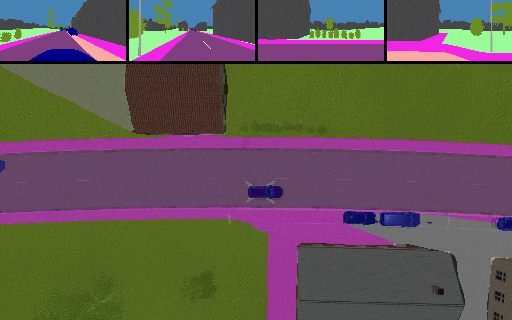

We'll work on several parts:
(0.) Imports
1. Data
(so far, no big deal, right?)
2. Custom Dataset Class
3. Model
4. Train
5. Run

Ready? Let's begin with the hardest part: **imports**!

## Imports

In [ ]:
!pip install torchgeometry

In [ ]:
import os
import sys
import cv2
import numpy as np
sys.path.append('/kaggle/input/cam2bev-frlr/cam2bev/cam2bev-data-master')
import matplotlib.pyplot as plt

## DL imports
import torch
import torch.nn as nn

Notice how with Kaggle, we're able to download the dataset only once, and then "plug" to it on the right immediately. To make sure it works, you should write the write path though.

## 1. Data
We'll be using the [Cam2BEV dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data) from [Sim2Real paper](https://browse.arxiv.org/pdf/2005.04078.pdf). It consists of Semantically Segmented images from Front, Rear, Left and Right cameras and corresponding BEV images. So, each image has been put to a segmentation model, and we use that as input, our label is a Bird Eye View image. Let's load and visualize it all.

In [ ]:
dataRootDir = '/kaggle/input/cam2bev-frlr/cam2bev/cam2bev-data-master/1_FRLR'
trainDir = os.path.join(dataRootDir, *['train'])
valDir = os.path.join(dataRootDir, *['val'])
examplesDir = os.path.join(dataRootDir, *['examples'])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

frontImg = load_image(os.path.join(examplesDir, *['front.png']))
leftImg = load_image(os.path.join(examplesDir, *['left.png']))
rearImg = load_image(os.path.join(examplesDir, *['rear.png']))
rightImg = load_image(os.path.join(examplesDir, *['right.png']))
bevImg = load_image(os.path.join(examplesDir, *['bev.png']))
bevOccImg = load_image(os.path.join(examplesDir, *['bev+occlusion.png']))

print(frontImg.shape)

In [ ]:
imageList = [frontImg, leftImg, rearImg, rightImg, bevImg, bevOccImg]
titlesList = ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV', 'BEV + OCCLUSION']

# function to plot single image
def plotImage(ax, img, title):
    imgHandle = ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')
    return imgHandle

fig, axes = plt.subplots(2,3, figsize= (16, 6))
for (ax,img,title) in zip(axes.flatten(), imageList, titlesList):
    plotImage(ax, img, title)
plt.show()

**Quick Note** Our examples are in PNG format, but the actual dataset is in NPY format (numPy), which is much lighter and easier to compress.

**Palette Mapping** <p> The colors on the image correspond to 30 classes in [Cityscapes dataset](https://www.cityscapes-dataset.com/). We'll need to convert the RGB image to One-hot encoded image. We'll need a color -> Class mapping which is defined as follows. 
- For the Input image, we'll group 30 classes to 10 classes in the input palette.
- For the Output image, we'll group 30 classes to 10 classes (including **Occlusion as the 10th class**) in the output palette.

In [ ]:
inputPalette = [
    [np.array([220,  64, 28])],                                                       # road  
    [np.array([244,  35, 232]), np.array([250, 170, 160])],                            # sidewalk
    [np.array([255,   0,   0])],                                                       # person   
    [np.array([32, 47, 70]), np.array([  0,   0, 142]), np.array([  0,   0, 110])],                            # car
    [np.array([ 0,  0, 70])],                                                          # Truck
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],                               # Bus
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])], # Two-wheelers
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),           # static obstacles
    np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),      
    np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),   
    np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
    np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100])],
    [np.array([152, 251, 152]),np.array([107, 142,  35])],                            # Vegetation
    [np.array([ 70, 130, 180])]                                                        # Sky
]


# Sky is added to Static obstacles and Occlusion is added as 10th class
outputPalette = [
    [np.array([220,  64, 28])],
    [np.array([244,  35, 232]), np.array([250, 170, 160])],
    [np.array([255,   0,   0])],
    [np.array([32, 47, 70]), np.array([  0,   0, 142]), np.array([  0,   0, 110])],
    [np.array([ 0,  0, 70])],
    [np.array([  0,  60, 100]), np.array([ 0,  0, 90])],
    [np.array([220,  20,  60]), np.array([  0,   0, 230]), np.array([119,  11,  32])],
    [np.array([0, 0, 0]), np.array([111,  74,   0]), np.array([81,  0, 81]),
     np.array([230, 150, 140]), np.array([70, 70, 70]), np.array([102, 102, 156]),
     np.array([190, 153, 153]), np.array([180, 165, 180]), np.array([150, 100, 100]),
     np.array([150, 120,  90]), np.array([153, 153, 153]), np.array([153, 153, 153]),
     np.array([250, 170,  30]), np.array([220, 220,   0]), np.array([  0,  80, 100]), np.array([ 70, 130, 180])],
    [np.array([152, 251, 152]), np.array([107, 142,  35])], 
    [np.array([150, 150, 150])]              # OCCLUSION CLASS
]

So now, let's visualize our NUMPY images, with this palette:

In [ ]:
print(len(image_test_front))

In [ ]:
image_test_front = np.load((os.path.join(trainDir,"front/t_0_0_0004000.npy"))).astype(np.float32)
plt.imshow(image_test_front[8])
plt.show()
print(image_test_front[8])

This image has been "one hot" encoded. It means that for each class, we have an image. If you want to view it as a real image, you'll need to use "one_hot_image_decode".

In [ ]:
import utils
image_view_front = utils.one_hot_decode_image(image_test_front, inputPalette)
plt.imshow(image_view_front)
plt.show()

So this was part 1 on data. Our data is **one hot encoded**, and we'll need to **one hot decode** it every time we want to use it. If you want to practice, try changing the road to "red" in the input image, or try using the output palette with the output Bird Eye View image.<p>
    Next, let's build a dataset.

## 2. Build a Custom Dataset
Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader. If you're not sure about PyTorch, please refer to my PyTorch cookbook! Out Dataset has 3 classes:
* **init**, which essentially initialize directories to select from
* **len**, which returns the number of images in the dataset
* **getitem**, which will load all the images (front, left, right, rear) and the labels (bird eye view) and return them as a numpy array.

In [ ]:
import utils  # module contains utility functions suchs as One hot encoding, resizing image 
from torch.utils.data import Dataset

class Cam2BEVDataset(Dataset):
    def __init__(self, input_dirs, label_dir):
        self.input_dirs = input_dirs
        self.label_dir = label_dir
        self.images = sorted(os.listdir(input_dirs[0]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        inputs = []
        
        # Load One hot encoded image 
        # Input = [Front, Left, Rear, Right]
        for i in self.input_dirs:
            oh_image_path = os.path.join(i, self.images[idx])
            image = np.load(oh_image_path).astype(np.float32)
            inputs.append(torch.from_numpy(image))
        
        # Label image => Load image -> One hot encode
        label_path = os.path.join(self.label_dir, self.images[idx])
        label = np.load(label_path).astype(np.float32)
        label = torch.from_numpy(label)
        return (inputs, label)

In [ ]:
trainInputDirs = [os.path.join(trainDir,x) for x in ['front', 'left', 'rear', 'right']]
trainLabelDir = os.path.join(trainDir, *['bev+occlusion'])
trainSet = Cam2BEVDataset(trainInputDirs, trainLabelDir)

# Visualize Random sample
inputImages, bevLabelImg = trainSet[np.random.randint(0, len(trainSet))]
print(f"There are {len(inputImages)} input images,")
print(f"Single input image shape = {inputImages[0].shape}, Label image shape = {bevLabelImg.shape}")

In [ ]:
fig, axes = plt.subplots(1, 5, figsize= (18, 12))

# plot Input images
for (ax,img,title) in zip(axes.flatten(), inputImages, ['FRONT', 'LEFT', 'REAR', 'RIGHT']):
    rgbImage = utils.one_hot_decode_image(img.detach().numpy(), inputPalette)
    plotImage(ax, rgbImage, title)

# plot label image
bevRgbImg = utils.one_hot_decode_image(bevLabelImg.detach().numpy(), outputPalette)
plotImage(axes.flatten()[-1], bevRgbImg, 'BEV LABEL')
plt.show()

In [ ]:
print(rgbImage.shape)

In [ ]:
# Create Validation dataset
valInputDirs = [os.path.join(valDir,x) for x in ['front', 'left', 'rear', 'right']]
valLabelDir = os.path.join(valDir, *['bev+occlusion'])
valSet = Cam2BEVDataset(valInputDirs, valLabelDir)
print(f"There are {len(valSet)} validation images")

In [ ]:
### CREATE PYTORCH DATALOADERS
from torch.utils.data import DataLoader
trainLoader = DataLoader(trainSet, batch_size=4, shuffle=True, num_workers=2)
valLoader = DataLoader(valSet, batch_size=8, shuffle=False, num_workers=2)

## 3. Model

We're going to use a model called as **UNetXST**. As the name suggests, its a UNet based model, with additional component where
- X stands for extension. The original UNet model was for single image semantic segmentation. Here, its being extended to mutiple images
- ST stands for Spatial Transformers

As with original UNet model, its an Encoder-Decoder architecture.

### Encoder
First, can you identify the encoder? Do the game on this link to begin: https://interacty.me/projects/8c45e17df1c7ff73
<p>So, what did you answer? The answer is...

A?

B?

D?

No!

It's:

(C)

Everything up to upsampling & prediction! So we have some work to do!
In particular, we should build:
* Convolutions
* Spatial Transformers
* Concatenations
![](https://production-media.paperswithcode.com/methods/uNetXST_RrnZp1g.jpg)

#### 1) Convolutions

**I am going to mess with you, but:**
    We can't really define the encoder blocks manually. I mean, look at a single convolution block, it's doing Conv+BatchNorm+ReLU+Maxpooling and if we want to,we can also use Dropout.

**init: We define the ingredients:**
So it means we would need to do:
```python
    block1 = nn.Sequential(nn.Conv2D(inputShape[-3], filters1, kernel_size=3, padding=1),
                      nn.BatchNorm2d(filters1),
                      nn.ReLU(True),
                      nn.Conv2D(filters1, filters1, kernel_size=3, padding=1),
                        nn.BatchNorm2d(filters1),
                       nn.ReLU(True),
                       nn.Maxpool2d(kernel_size=2, stride=2)
                       nn.Dropout2d(p=0.1))
```
And we would need to do that 4 times, every time adjusting the filters, and making sure we don't do the pooling at the last block. This is too much, so let's see a smarter way instead.
    
    Note: In the paper, you can see 3 convolutions, yet the authors use 5. In the official implementation, you can see 4 being used, and sometimes you can see pretrained backbones like DeepLab instead.<p> After all, starting from scratch can be annoying, so we could use Transfer Learning. In our case, let's simply define 4 convolutions; and remember that the last one does not have maxpooling and relu.
    
    
**forward: We compose our salad!** So we define the layers one after the other. Important: We want to "save" the output before Maxpooling, because this output will be passed to the Spatial Transformer.
    
    

In [ ]:
class Encoder(nn.Module):
    def __init__(self, inputShape, u_depth, filters1):
        super(Encoder, self).__init__()
        # We define the depth we want to use
        self.u_depth = u_depth
        # We create a structure for our layers
        self.encoder_layers = nn.ModuleList()
        # We define the input filters
        filters = inputShape[-3]
        # And the output filters
        filters_ = filters1
        
        # For each "layer", we implement our block - the filters are dynamic
        for d in range(self.u_depth):
            layer = nn.Sequential(
                nn.Conv2d(filters, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
                nn.Conv2d(filters_, filters_, kernel_size=3, padding=1),
                nn.BatchNorm2d(filters_),
                nn.ReLU(True),                
            )
            
            # If we're not at the last layer, we add Maxpooling.
            if d<(self.u_depth-1):
                layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
                layer.append(nn.Dropout2d(p=0.1))
            
            # We then adjust our filters to go deeper at the next layer
            filters = filters_
            filters_ = (2**(d+1))*filters1
            
            # We add the layer to our structure
            self.encoder_layers.append(layer)

    def forward(self, x):
        # We define our layers
        encoder_layers = []
        # We create an intermediate buffer not to modify our input
        t = x
        
        # For each layer
        for d in range(self.u_depth):
            # if it's not the last layer
            if d<(self.u_depth-1):
                # Apply all but the last 2 operations (MaxPool & Dropout)
                t = self.encoder_layers[d][:-2](t)
                # Store the output so Spatial Transformers use it
                encoder_layers.append(t)
                # We then apply these last 2 operations
                t = self.encoder_layers[d][-2:](t)
            else:
                # The last layer doesn't have Maxpool & Dropout, so we apply all.
                t = self.encoder_layers[d](t)
                encoder_layers.append(t)

        return encoder_layers

In [ ]:
encoderModule = Encoder(inputShape=(10,256,512), u_depth=4, filters1=16).to(device)

# Generate sample data, assuming batchsize of 1
# singleCameraData = torch.rand(1, 10, 256, 512).to(device)
singleCameraData = inputImages[0].unsqueeze(0).to(device)
encoderOutput = encoderModule(singleCameraData)
print(f"Len of encoderOutput = {len(encoderOutput)}")
print(f"Encoder outputs = {[x.shape for x in encoderOutput]}")

In [ ]:
print(encoderModule.encoder_layers)

#### 2) Spatial Transformers

[Spatial Transformer Networks](https://browse.arxiv.org/pdf/1506.02025.pdf) are special class of Neural Network, that help CNN architectures be more robust to spatial variations (Rotation, Translation, Shearing etc)

- In this architecture, STN module is used to convert Front facing Image to BEV (Birds Eye View). 
- **The Homography transformation specific to each camera, is fed as input to the STN module**
- STN = Deep Learning variant to achieve in IPM (Inverse Perspective Mapping)
- In ideal case, the transformation parameters will be regressed by the module itself. But that requires long training hours, careful monitoring of loss and regularization. Hence, feeding the reference Homography matrix serves as geometric prior for the model 

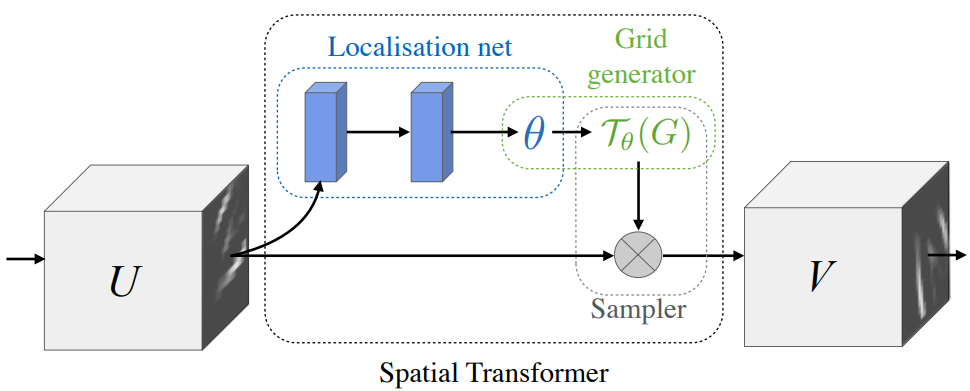

We will use the function "HomographyWarper" from torchgeometry. You can read it [here](https://kornia.readthedocs.io/en/v0.1.2/_modules/torchgeometry/core/homography_warper.html).

In [ ]:
import torchgeometry as tgm
import torch.nn.functional as F

class STN(nn.Module):
    def __init__(self, inputShape, theta):
        super(STN, self).__init__()
        self.theta = theta
        self.warper = tgm.HomographyWarper(inputShape[-2], inputShape[-1])

    def forward(self, x):
        bs = x.shape[0]
        x = self.warper(x, self.theta.repeat(bs,1,1))
        return x

Now, and this is the "geometric" part, we're going to feed a Homography matrix we calculated. There is one for each camera, because the bird eye view conversions are independent for each camera.

In [ ]:
H = [
  np.array([[4.651574574230558e-14, 10.192351107009959, -5.36318723862984e-07], [-5.588661045867985e-07, 0.0, 2.3708767903941617], [35.30731833118676, 0.0, -1.7000018578614013]]),                                       # front
  np.array([[20.38470221401992, 7.562206982469407e-14, -0.28867638384075833], [-3.422067857504854e-23, 2.794330463189411e-07, 2.540225111648729], [2.1619497190382224e-15, -17.65365916559334, -0.4999990710692976]]),    # left    
  np.array([[-5.336674306912119e-14, -10.192351107009957, 5.363187220578325e-07], [5.588660952931949e-07, 3.582264351370481e-23, 2.370876772982613], [-35.30731833118661, -2.263156574813233e-15, -0.5999981421386035]]), # rear
  np.array([[-20.38470221401991, -4.849709834037436e-15, 0.2886763838407495], [-3.4220679184765114e-23, -2.794330512976549e-07, 2.5402251116487626], [2.161949719038217e-15, 17.653659165593304, -0.5000009289306967]])   # right
]

H = [torch.from_numpy(x).float().to(device) for x in H]

We could test it by creating a simple model on the front image (H[0]):

In [ ]:
stnModule = STN(inputShape=(1,256,512), theta=H[0]).to(device)
stnOutput = stnModule(encoderOutput[0])
print(f"stnOutput shape = {stnOutput.shape}")

We could also plot out feature maps, and transformed maps, but to make sense, keep in mind that we're still before training here, so it'll be better **after** training.

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize= (18, 12))

# plot Input images
plotImage(ax0, encoderOutput[0].detach().cpu().numpy()[0][1], "Feature Map")
plotImage(ax1, stnOutput.detach().cpu().numpy()[0][1], "STN Transformed")
plt.show()

In [ ]:
print(stnOutput.detach().cpu().numpy().shape)

This is all we need to convert a single image to BEV (Birds Eye View). After adding a decoder, we can train the model with BEV image for the single view as label. There is a [Cam2BEV 2F dataset](https://gitlab.ika.rwth-aachen.de/cam2bev/cam2bev-data/-/tree/master/2_F) that contains just the Front facing camera along with corresponding BEV image


#### 3) Concatenation (Combine Multiple Images to get 360° BEV image)
We will learn how to combine the **transformed / warped images to get a 360degree BEV**. We'll call it the **Joiner** module. At each level (depth), the joiner module combines the 4 warped images to give a single output image, which is fed to the decoder module.

**Implementation**<p>
    Similarly to the encoder, we don't want to manually define a set of convolutions and concatenations 4 times, so we'll use a loop and modify variables to implement it continuously. For your reference, an original concatenation is:<p>

```python

## For Each Images, assuming we do it after the first convolution
shape = (filters, width//2, height//2) # this will change as we get deeper
for i in range(self.n_inputs):
     self.depth_stn_layers.append(STN(tuple(shape), H[i]))

## Then down the line in forward you concatenate:
warped_maps = []
for i in range(self.n_inputs): # for each image
    t = self.depth_stn_layers[i](encoder_outputs[i])
    warped_maps.append(t)

torch.cat(warped_maps, dim=1) #concatenate
```

In [ ]:
class Joiner(nn.Module):
    def __init__(self, inputShape, udepth, n_inputs, filters1, returnWarpedOutput=False):
        super(Joiner, self).__init__()
        self.n_inputs = n_inputs
        self.filters1 = filters1
        self.joiner_outputs = []
        self.joiner_layers = nn.ModuleList()
        self.depth_stn_layers = nn.ModuleList()
        self.returnWarpedOutput = returnWarpedOutput  
        
        shape = list(inputShape)
        for d in range(udepth):
            layer = []
            filters = (2**d)*self.filters1
            warped_maps = []
            stn_layers = nn.ModuleList()
            for i in range(self.n_inputs):
                shape[-3] = filters
                shape[-2] = inputShape[-2]//(2**d)
                shape[-1] = inputShape[-1]//(2**d)
                stn_layers.append(STN(tuple(shape), H[i]))

            self.depth_stn_layers.append(stn_layers)
            layer.append(nn.Conv2d(filters*n_inputs, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            layer.append(nn.Conv2d(filters, filters, kernel_size=3, padding = 1))
            layer.append(nn.BatchNorm2d(filters))            
            layer.append(nn.ReLU(True))
            self.joiner_layers.append(nn.Sequential(*layer))
    
    def warpedOutput(self, flag):
        self.returnWarpedOutput = flag
    
    def forward(self, encoder_outputs):
        self.joiner_outputs = []
        warped_outputs = []
        
        for d in range(len(encoder_outputs[0])):
            filters = (2**d)*self.filters1
            warped_maps = []
            for i in range(self.n_inputs):
                t = self.depth_stn_layers[d][i](encoder_outputs[i][d])
                warped_maps.append(t)
            t = torch.cat(warped_maps, dim=1) if self.n_inputs > 1 else warped_maps[0]
            if(self.returnWarpedOutput):
                warped_outputs.append([x.cpu().detach().numpy() for x in warped_maps])            
            t = self.joiner_layers[d](t)
            self.joiner_outputs.append(t)
                
        if(self.returnWarpedOutput):
            return self.joiner_outputs, warped_outputs
        else:
            return self.joiner_outputs

In [ ]:
joinerModule = Joiner(inputShape=(10,256,512), udepth=4, n_inputs=4, filters1=16, returnWarpedOutput=True).to(device)
joinerOutput, warped_outputs = joinerModule([encoderOutput for i in range(4)])   # simulate inputs from 4 cameras
print(f"Joiner module output = {[x.shape for x in joinerOutput]}")

## Decoder 
The Decoder module is very similar to the UNet with
- Upsampling the lower level's output and concatenating with output from 1 level above
- Skip connection at each level to improve **improved boundaries segmentation**

The only difference being, the **Joiner output is fed to decoder (as it contains multiple images output) instead of Encoder output**

In [ ]:
sys.path.append("/kaggle/input/cam2bev-frlr/")
from model_utils import Decoder, plot_training_results, meanIoU

In [ ]:
decoderModule = Decoder(udepth=4, filters1=16).to(device)
decoderOutput = decoderModule(joinerOutput) 
print(f"decoderOutput module output = {decoderOutput.shape}")

### Putting it together - UNetXST

In [ ]:
class UNetXST(nn.Module):
    def __init__(self, inputShape, nInputs, nOutputClasses, udepth, filters1, returnWarpedOutput=False):
        super(UNetXST, self).__init__()
        self.inputShape = inputShape        
        self.nInputs = nInputs
        self.nOutputClasses = nOutputClasses
        self.udepth = udepth
        self.filters1 = filters1
        self.returnWarpedOutput = returnWarpedOutput

        self.encoder = nn.ModuleList([Encoder(self.inputShape, self.udepth, self.filters1) for i in range(nInputs)])
        self.joiner = Joiner(self.inputShape, self.udepth, self.nInputs, self.filters1, returnWarpedOutput=self.returnWarpedOutput)
        self.decoder = Decoder(self.udepth, self.filters1)

        self.prediction = nn.Sequential(
            nn.Conv2d(self.filters1, nOutputClasses, kernel_size=3, padding=1),
            nn.Softmax(dim=1)
        )

    def forward(self, inputs):
        encoder_outputs = []
        for i in range(self.nInputs):
            encoder_outputs.append(self.encoder[i](inputs[i]))
            
        if(self.returnWarpedOutput):
            joiner_output, warped_outputs = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction, warped_outputs
            
        else:
            joiner_output = self.joiner(encoder_outputs)
            decoder_output = self.decoder(joiner_output)
            prediction = self.prediction(decoder_output)
            return prediction            


In [ ]:
model = UNetXST(inputShape =(10, 256, 512), nInputs= 4, nOutputClasses=10, udepth=4, filters1=16, returnWarpedOutput=True).to(device)
print(model)

## 4 - Training the model

We'll train the model using the following settings
- **Dice loss function** - as Semantic Segmentation is simply pixel-wise Classification
- **meanIoU Metric** - Mean Intersection over Union
- **Adam Optimizer** - converges faster and often, very good baseline
- **One Cycle LR** learning rate scheduler

We'll train some helper functions / classes to train, validate the model

In [ ]:
def evaluate_model(model, dataloader, criterion, metric_class, device):
    model.eval()
    total_loss = 0.0
    metric_object = metric_class(NUM_CLASSES)

    with torch.no_grad():
        for inputs,labels in tqdm(dataloader, total=len(dataloader)):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            y_preds, _ = model(inputs)

            # calculate loss
            loss = criterion(y_preds, labels)
            total_loss += loss.item()

            # update batch metric information            
            metric_object.update(y_preds.cpu().detach(), labels.cpu().detach())

    evaluation_loss = total_loss / len(dataloader)
    evaluation_metric = metric_object.compute()
    return evaluation_loss, evaluation_metric

In [ ]:
import pandas as pd
from tqdm import tqdm

def train_validate_model(model, num_epochs, model_name, criterion, optimizer, 
                         device, dataloader_train, dataloader_valid, 
                         metric_class, metric_name, lr_scheduler = None):
    # initialize placeholders for running values
    results = []    
    min_val_loss = np.Inf
    len_train_loader = len(dataloader_train)

    # move model to device
    model.to(device)
    
    for epoch in range(num_epochs):
        print(f"Starting {epoch + 1} epoch ...")
        
        # Training
        model.train()
        train_loss = 0.0
        for inputs,labels in tqdm(dataloader_train, total=len_train_loader):
            inputs = [x.to(device) for x in inputs]
            labels = labels.to(device)            
            _, labels = labels.max(dim=1) # converting to single channel output
            
            # Forward pass
            y_preds, warped = model(inputs)
            loss = criterion(y_preds, labels)
            train_loss += loss.item()
              
            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # adjust learning rate
            if lr_scheduler is not None:
                lr_scheduler.step()
            
        # compute per batch losses, metric value
        train_loss = train_loss / len(dataloader_train)
        validation_loss, validation_metric = evaluate_model(
                        model, dataloader_valid, criterion, metric_class, device)

        print(f'Epoch: {epoch+1}, trainLoss:{train_loss:6.5f}, validationLoss:{validation_loss:6.5f}, {metric_name}:{validation_metric: 4.2f}')
        
        # store results
        results.append({'epoch': epoch, 'trainLoss': train_loss, 'validationLoss': validation_loss, f'{metric_name}': validation_metric})
        
        # if validation loss has decreased, save model and reset variable
        if validation_loss <= min_val_loss:
            min_val_loss = validation_loss
            torch.save(model.state_dict(), f"{model_name}.pt")

    # plot results
    results = pd.DataFrame(results)
    plot_training_results(results, model_name)
    return results

In [ ]:
# class weight is inversely proportional to % of class in entre training dataset
weights = np.array([0.98684351, 2.2481491, 10.47452063, 4.78351389, 7.01028204, 8.41360361, 10.91633349, 2.38571558, 1.02473193, 2.79359197])
normalizedWeights = (weights / np.sum(weights))
normalizedWeights = torch.from_numpy(normalizedWeights).float().to(device)

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss(weight=normalizedWeights)

# MODEL HYPERPARAMETERS
N_EPOCHS = 2
NUM_CLASSES = 10
MAX_LR = 1e-3
MODEL_NAME = 'UNetXST_CosAnneal_1e-3'

# create model, optimizer, lr_scheduler and pass to training function
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(trainLoader) * float(N_EPOCHS)/10), eta_min=3e-4)


_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, trainLoader, valLoader, meanIoU, 'meanIoU',
                         lr_scheduler = scheduler)

### Otherwise, run the pretrained weights

In [ ]:
path = "/kaggle/input/cam2bev-frlr/UNetXST_CosAnneal_1e-3.pt"
model.load_state_dict(torch.load(path))

## Visualize Model Predictions

We'll run the model through ordered Validation set, store the predicted semantic images along with input semantic images

In [ ]:
# One-hot encoding -> color mapping Decoders
inputDecoder = torch.from_numpy(np.array([x[0] for x in inputPalette])).to(device)
outputDecoder = torch.from_numpy(np.array([x[0] for x in outputPalette])).to(device)

In [ ]:
# Placeholder for storing output
output = {}
for view in ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']:
    output[f"{view}"] = []
    
# redefine validation loader, but with shuffle set to False
valLoader = DataLoader(valSet, batch_size=8, shuffle=False, num_workers=2)

with torch.no_grad():
    for inputs,labels in tqdm(valLoader, total=len(valLoader)):
        inputs = [x.to(device) for x in inputs]
        y_preds, warped = model(inputs)
        labels = labels.to(device)
        
        # One-hot encoding -> Class Index -> RGB image based on color map
        decodedInputs = [inputDecoder[torch.argmax(x, dim=1)].cpu().detach().numpy() for x in inputs]
        decodedOutputs = outputDecoder[torch.argmax(y_preds, dim=1)].cpu().detach().numpy()
#         decodedLabels = outputDecoder[torch.argmax(labels, dim=1)].cpu().detach().numpy()
        
        # store each sample output as separate item
        for i in range(decodedInputs[0].shape[0]):
            output['FRONT'].append(decodedInputs[0][i])
            output['LEFT'].append(decodedInputs[1][i])
            output['REAR'].append(decodedInputs[2][i])
            output['RIGHT'].append(decodedInputs[3][i])
            output['BEV_PREDS'].append(decodedOutputs[i])
#             output['BEV_PREDS'].append(decodedLabels[i])

In [ ]:
plt.imshow(decodedOutputs[3])
plt.show()

In [ ]:
import matplotlib.animation as animation

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
fig, axes = plt.subplot_mosaic([['FRONT', 'LEFT', 'REAR', 'RIGHT'], ['BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS']],
                               height_ratios=[0.4, 0.6], figsize=(10, 8))

imgHandles = []
for title,ax in axes.items():
    imgHandles.append(ax.imshow(np.random.rand(256,512)))
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()

def run(index, data, imgHandles):
    for i,view in enumerate(['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']):
        imgHandles[i].set_data(output[view][index])
    return imgHandles

ani = animation.FuncAnimation(fig, run, len(output['FRONT']), fargs=(output, imgHandles), blit=True, interval=10, repeat=False)

In [ ]:
ani.save('BEV_output.mp4', writer=writer, dpi=100)

## BEV Feature Visualization

In [ ]:
warped[0][0][0].shape

In [ ]:
plt.imshow(decoderOutput.cpu().detach().numpy()[0][0])

In [ ]:
fig, axes = plt.subplot_mosaic([['FRONT', 'LEFT', 'REAR', 'RIGHT'], 
                                ['FRONT_BEV', 'LEFT_BEV', 'REAR_BEV', 'RIGHT_BEV'], 
                                ['BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS', 'BEV_PREDS']],
                               height_ratios=[0.4, 0.3, 0.4], figsize=(18,12))

for title, ax in axes.items():
    ax.axis('off')

for view in ['FRONT', 'LEFT', 'REAR', 'RIGHT', 'BEV_PREDS']:
    axes[view].imshow(output[view][-1])
    axes[view].set_title(view)

axes['FRONT_BEV'].imshow(warped[0][0][-1][0], cmap='inferno')
axes['LEFT_BEV'].imshow(warped[0][1][-1][0], cmap='inferno')
axes['REAR_BEV'].imshow(warped[0][2][-1][0], cmap='inferno')
axes['RIGHT_BEV'].imshow(warped[0][3][-1][0], cmap='inferno')
plt.tight_layout()
plt.show()